In [1]:
import os
import torch
import argparse
import numpy as np

from engine.logger import Logger
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader, build_dataloader_cond
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.io_utils import load_yaml_config, seed_everything, merge_opts_to_config, instantiate_from_config
from Utils.metric_utils import visualization

import sys
import time
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from tqdm import tqdm
from ema_pytorch import EMA
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from Utils.io_utils import instantiate_from_config, get_model_parameters_info


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                        
import seaborn as sns 

from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae
import random

2025-10-25 21:18:21 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [3]:
def visualization2(ori, gen):
    
    Number = ori.shape[0]
    
    max_sample = min([4000, Number])      
    idx = np.random.permutation(Number)[ :max_sample]

    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]

    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 

    concat_data = np.concatenate((ori1, gen1), axis=0)
    
    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=42)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)
    

In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Training Script')
    parser.add_argument('--name', type=str, default=None)

    parser.add_argument('--config_file', type=str, default=None, 
                        help='path of config file')
    parser.add_argument('--output', type=str, default='OUTPUT', 
                        help='directory to save the results')
    parser.add_argument('--tensorboard', action='store_true', 
                        help='use tensorboard for logging')

    # args for random

    parser.add_argument('--cudnn_deterministic', action='store_true', default=False,
                        help='set cudnn.deterministic True')
    parser.add_argument('--seed', type=int, default=10, 
                        help='seed for initializing training.')
    parser.add_argument('--gpu', type=int, default=None,
                        help='GPU id to use. If given, only the specific gpu will be'
                        ' used, and ddp will be disabled')
    
    # args for training
    parser.add_argument('--train', action='store_true', default=False, help='Train or Test.')
    parser.add_argument('--sample', type=int, default=0, 
                        choices=[0, 1], help='Condition or Uncondition.')
    parser.add_argument('--mode', type=str, default='infill',
                        help='Infilling or Forecasting.')
    parser.add_argument('--milestone', type=int, default=10)

    parser.add_argument('--missing_ratio', type=float, default=0., help='Ratio of Missing Values.')
    parser.add_argument('--pred_len', type=int, default=0, help='Length of Predictions.')
    
    
    # args for modify config
    parser.add_argument('opts', help='Modify config options using the command-line',
                        default=None, nargs=argparse.REMAINDER)  

    args = parser.parse_args(args=[])
    args.save_dir = os.path.join(args.output, f'{args.name}')

    return args


In [5]:
args = parse_args()

# data_name = 'ETTh1'
# data_name = 'Energy'
# data_name = 'weather'
data_name = 'exchange_rate'


    
if data_name == 'ETTh1':
    args.config_file =  './Config/ETTh1.yaml'

elif data_name == 'Energy':
    args.config_file =  './Config/Energy.yaml'

elif data_name == 'weather':
    args.config_file =  './Config/weather.yaml'
    
elif data_name == 'exchange_rate':
    args.config_file =  './Config/exchange_rate.yaml'
    
args.gpu =  0
args.train = True
print(args)

Namespace(name=None, config_file='./Config/exchange_rate.yaml', output='OUTPUT', tensorboard=False, cudnn_deterministic=False, seed=10, gpu=0, train=True, sample=0, mode='infill', milestone=10, missing_ratio=0.0, pred_len=0, opts=[], save_dir='OUTPUT\\None')


In [6]:
if args.seed is not None:
    seed_everything(args.seed)

if args.gpu is not None:
    torch.cuda.set_device(args.gpu)

config = load_yaml_config(args.config_file)
config = merge_opts_to_config(config, args.opts)


config['dataloader']['batch_size'] = 200
print(config)

beta_schedule = config['model']['params']['beta_schedule'] 
timesteps = config['model']['params']['timesteps'] 
print(beta_schedule, timesteps)

Global seed set to 10
{'model': {'target': 'Models.interpretable_diffusion.gaussian_diffusion.Diffusion_TS', 'params': {'seq_length': 24, 'feature_size': 8, 'n_layer_enc': 4, 'n_layer_dec': 3, 'd_model': 96, 'timesteps': 500, 'sampling_timesteps': 500, 'loss_type': 'l1', 'beta_schedule': 'cosine', 'n_heads': 4, 'mlp_hidden_times': 4, 'attn_pd': 0.0, 'resid_pd': 0.0, 'kernel_size': 1, 'padding_size': 0}}, 'solver': {'base_lr': 1e-05, 'max_epochs': 25000, 'results_folder': './Checkpoints_energy', 'gradient_accumulate_every': 2, 'save_cycle': 2500, 'ema': {'decay': 0.995, 'update_interval': 10}, 'scheduler': {'target': 'engine.lr_sch.ReduceLROnPlateauWithWarmup', 'params': {'factor': 0.5, 'patience': 5000, 'min_lr': 1e-05, 'threshold': 0.1, 'threshold_mode': 'rel', 'warmup_lr': 0.0008, 'warmup': 500, 'verbose': False}}}, 'dataloader': {'train_dataset': {'target': 'Utils.Data_utils.real_datasets.CustomDataset', 'params': {'name': 'energy', 'proportion': 1.0, 'data_root': './Data/datasets/e

In [7]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



if data_name == 'ETTh1':
    load_data = np.load( './Data/datasets/ETTh1.npy')
    
elif data_name == 'Energy':
    load_data = np.load( './Data/datasets/Energy.npy')

    
elif data_name == 'weather':
    load_data = np.load( './Data/datasets/weather.npy')
    
elif data_name == 'exchange_rate':
    load_data = np.load( './Data/datasets/exchange_rate.npy')
    
    
np.random.shuffle(load_data)


Numble = load_data.shape[0]
Length = load_data.shape[1]
Feature = load_data.shape[2]
   
shape = (Numble, Length, Feature)
print(shape)

(2522, 24, 8)


In [8]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(x):
    return x is not None

from Models.interpretable_diffusion.model_utils import default, identity, extract
from Models.interpretable_diffusion.gaussian_diffusion import linear_beta_schedule, cosine_beta_schedule, Diffusion_TS
import torch.nn.functional as F


# load shortcut

In [9]:
rf_model = instantiate_from_config(config['model']).cuda()

device = rf_model.betas.device

In [11]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(rf_model, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=start_lr, betas=[0.9, 0.96])
sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt   
sch = instantiate_from_config(sc_cfg)   


In [12]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(5, replacement=True).to(device)]

t = torch.rand(size=(10, 1), device=device)

def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))

In [13]:
padding_masks = None
clip_x_start = False
clip_denoised = True

In [14]:
rf_model = instantiate_from_config(config['model']).cuda()

rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_rf.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_ema_rf.pth"  ))


<All keys matched successfully>

In [19]:
from torch.autograd import Variable

def get_mask_mcar(sample, mr): 
    mask = torch.ones(sample.shape).view(1,-1) 
    index = torch.tensor(range(mask.shape[1]))  
    perm = torch.randperm(len(index)) 
    index = perm[ 0: round( mr*len(index) ) ]
    mask[0][index]=0
    mask = mask.view(sample.shape)
    return mask


def get_mask_mnr(sample, k): 
    mask = torch.ones(sample.shape)
    length_index = torch.tensor(range(mask.shape[0]))
    list_of_segments_index = torch.split(length_index, k)
    for channel in range(mask.shape[1]):
        s_nan = random.choice(list_of_segments_index)
        mask[:, channel][s_nan[0]:s_nan[-1] + 1] = 0

    return mask


# initialize code randomly

In [20]:
target = torch.tensor( load_data[0:1000] ).float().cuda()
shape = target.shape
print(shape)

b, c, n, = target.shape

code = torch.randn(shape, device=device)
initial_data = Variable( code, requires_grad=True)
optimizer = torch.optim.Adam(  [initial_data], lr=0.01)  
padding_masks = torch.ones(b, c, dtype=bool, device=device)

torch.Size([1000, 24, 8])


# choose missing rate, mechanism 

In [21]:
mr = 0.3
# mechanism = 'mcar'  
mechanism = 'mnr'
missing_length = int( mr * Length )


Mask = torch.empty([0, c, n])    
print( Mask.shape)

for i in range(target.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( target[0], mr)  
    else:
        one_mask = get_mask_mnr( target[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask = torch.row_stack([Mask, one_mask])

Mask = Mask.float().cuda()
print( Mask.shape )

torch.Size([0, 24, 8])
torch.Size([1000, 24, 8])


# optimize random code 

In [22]:
n_steps = 50
eps = 1e-8

d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)

loss_list = []
loss_missing_list = []

iteration = 300
pbar = tqdm( total=iteration )   

for i in range(0,iteration):

    x_t = initial_data

    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))

        with torch.no_grad():

            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
        
    res_random = x_t

    loss = F.mse_loss( x_t* Mask, target*Mask, reduction="none")
    loss = loss.sum()/Mask.sum()
    
    loss_missing = F.mse_loss( x_t*(1-Mask), target*(1-Mask), reduction="none")
    loss_missing = loss_missing.sum()/(1-Mask).sum()
    loss_missing_list.append(loss_missing.item() )


    loss.float().backward() 
    optimizer.step()
    optimizer.zero_grad()
    
    loss_list.append(loss.item() )

    pbar.update(1)
    
pbar.close()


  5%|████▏                                                                            | 26/500 [01:22<25:07,  3.18s/it]

 22%|█████████████████▌                                                               | 65/300 [01:56<06:52,  1.76s/it]


 44%|██████████████████████████████████▉                                             | 131/300 [03:50<04:54,  1.75s/it]


 66%|████████████████████████████████████████████████████▌                           | 197/300 [05:46<02:56,  1.71s/it]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [07:59<01:26,  2.34s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [09:08<00:00,  1.83s/it]


[0.01825850960257049, 0.018247761371328292, 0.018237036328977642, 0.018226315354831196, 0.0182155696966897]


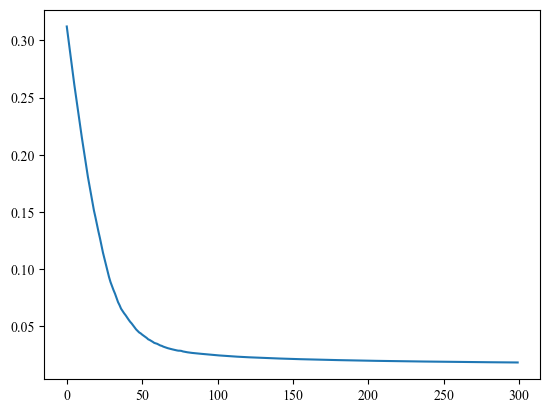

In [23]:
rmse1 = list( map(lambda x: x ** (1/2), loss_list) )
rmse2 = list( map(lambda x: x ** (1/2), loss_missing_list) )

print( rmse2[-5:]  )

plt.figure()
# plt.plot(rmse1)
plt.plot(rmse2)

# RMSE by random initialization

In [24]:
rmse = calc_rmse(res_random, target,1-Mask).cpu()
print( 'RMSE', rmse )

result_pre = res_random

RMSE tensor(0.0182, grad_fn=<ToCopyBackward0>)


# use extra inversion and refinement steps to refine result from random initialization

In [25]:
n_steps =100  
eps = 1e-8
d = torch.tensor(1 / n_steps).to(device)

In [29]:
loss_list = []
loss_missing_list = []

inversion_iter = 1
refine_iter = 5

pbar = tqdm( total= inversion_iter * refine_iter + inversion_iter )   #

for j in range(0, inversion_iter  ):
    
    if j==0:       
        x_t = torch.tensor( res_random ).cuda()*(1- Mask) + target*Mask
    else:         
        x_t = refined_res*(1- Mask) + target*Mask
        
    t = torch.linspace( 1-eps, eps, n_steps+1 ).to(device)

    '------------- vanilla flow inversion------------'
    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))
        with torch.no_grad():
            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 
        x_t = x_t - (t[i-1] - t[i]) * v_pred
        
    inverted_code = Variable( x_t, requires_grad=True)
    optimizer = torch.optim.Adam(  [inverted_code], lr=0.001)  

    pbar.update(1)
    
    
    '------------------ vanilla flow sampling---------------'
    t = torch.linspace( eps, 1-eps , n_steps+1 ).to(device)
        
    for i in range(0, refine_iter):
        
        x_t = inverted_code

        for i in range(1, len(t)):
            t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
            d_batch = d.unsqueeze(0).repeat((b,))

            with torch.no_grad():
                v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

            x_t = x_t + (t[i] - t[i - 1]) * v_pred

        refined_res = x_t

        loss = F.mse_loss( x_t*Mask , target*Mask , reduction="none")
        loss = loss.sum()/Mask.sum()
        loss_list.append(loss.item() )


        loss_missing = F.mse_loss( x_t*(1-Mask), target*(1-Mask), reduction="none")
        loss_missing = loss_missing.sum()/(1-Mask).sum()
        loss_missing_list.append(loss_missing.item() )


        loss.float().backward() 
        optimizer.step()
        optimizer.zero_grad()

        pbar.update(1)

pbar.close()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\PC123\AppData\Local\Temp\ipykernel_36576\3717884182.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t = torch.tensor( res_random ).cuda()*(1- Mask) + target*Mask
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.38s/it]


[0.01837 0.01804 0.0178  0.01763 0.01751]


Text(0.5, 1.0, 'evolution of refined RMSE')

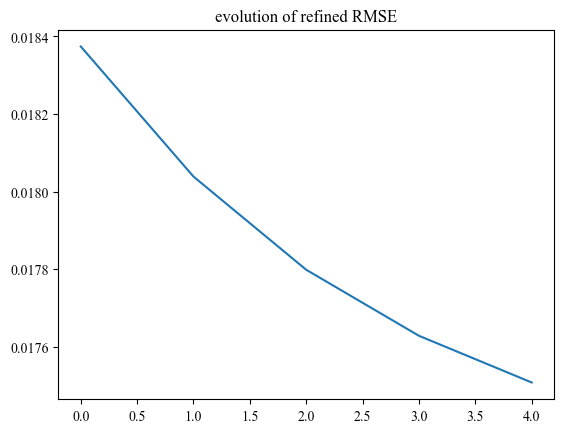

In [30]:
rmse1 = list( map(lambda x: x ** (1/2), loss_list) )
rmse2 = list( map(lambda x: x ** (1/2), loss_missing_list) )
print( np.around( rmse2, 5 )  )

plt.figure()
# plt.plot(rmse1)
plt.plot(rmse2)
plt.title('evolution of refined RMSE')

# refined RMSE from random initialization

In [31]:
rmse = calc_rmse( refined_res, target,1-Mask).cpu()
mae = calc_mae( refined_res, target, 1-Mask).cpu() 
print( 'RMSE', rmse )
print( 'MAE', mae )

RMSE tensor(0.0175, grad_fn=<ToCopyBackward0>)
MAE tensor(0.0110, grad_fn=<ToCopyBackward0>)
